## Lab 3
### Part 1: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print("Directory", path, "is created!")
    else:
        print("Directory", path, "already exists!")


root_path = "fmnist"
mkdir(root_path)

Directory fmnist already exists!


In [110]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(
    root_path, train=True, transform=train_transform, target_transform=None, download=download
)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(
    root_path, train=False, transform=test_transform, target_transform=None, download=download
)

In [111]:
train_loader = torch.utils.data.DataLoader(
    fmnist_dataset_train, batch_size=128, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    fmnist_dataset_test, batch_size=256, shuffle=False, num_workers=2
)

In [112]:
len(fmnist_dataset_train), len(fmnist_dataset_test)

(60000, 10000)

In [6]:
for img, label in train_loader:
    print(img.shape)
    #     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


In [7]:
import matplotlib.pyplot as plt

In [8]:
img = img.reshape(128, 28, 28)
img.sum(axis=0).shape

torch.Size([28, 28])

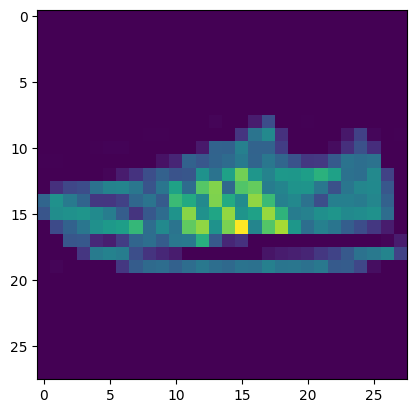

In [9]:
plt.imshow(X=img[3].reshape(28, 28),)

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [10]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            #nn.Linear(input_shape, num_classes)
            nn.Linear(input_shape, 20*20),
            nn.BatchNorm1d(num_features=20*20),
            nn.LeakyReLU(),
            nn.Linear(20*20, num_classes),
        )
        
    def forward(self, inp):       
        return self.model(inp)
        out =  self.model(inp)

In [11]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 400]         314,000
       BatchNorm1d-3                  [-1, 400]             800
         LeakyReLU-4                  [-1, 400]               0
            Linear-5                   [-1, 10]           4,010
Total params: 318,810
Trainable params: 318,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.22
Estimated Total Size (MB): 1.23
----------------------------------------------------------------


Your experiments come here:

In [24]:
from torch.optim import Adam

In [25]:
model = TinyNeuralNetwork().to(device)
opt = Adam(params=model.parameters(), lr=1e-4,) #eps=1e-8, betas=(0.9, 0.999), weight_decay=0.99) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

In [26]:
import time

In [28]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, chname: str):
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []
    
    best_ep = 0
    best_acc = 0
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_train_accuracy = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            ### YOUR CODE HERE
            X_batch = X_batch.to(device, torch.float32)
            y_batch = y_batch.to(device, torch.long)
            X_batch.requires_grad = True
            #y_batch.requires_grad = True

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            model.zero_grad()

            predictions = model(X_batch)
            loss = loss_fn.forward(input=predictions, target=y_batch)
            loss.backward()
            opt.step()

            ep_train_loss.append(loss.item())
            y_pred = predictions.max(axis=-1).indices ### YOUR CODE HERE
            accuracy = (y_pred == y_batch).detach().cpu().numpy().mean()
            ep_train_accuracy.append(accuracy)

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            # validation set
            for X_batch, y_batch in val_loader:
                # move data to target device
                ### YOUR CODE HERE
                X_batch = X_batch.to(device, torch.float32)
                y_batch = y_batch.to(device, torch.long)
                # compute predictions
                ### YOUR CODE HERE
                predictions_val = model(X_batch)
                ep_val_loss.append(loss_fn(input=predictions_val, target=y_batch).item())
                y_pred = predictions_val.max(axis=-1).indices ### YOUR CODE HERE
                accuracy = (y_pred == y_batch).detach().cpu().numpy().mean()
                ep_val_accuracy.append(accuracy)

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        train_accuracy.append(np.mean(ep_train_accuracy))

        new = val_accuracy[-1]
        if new > best_acc:
            best_acc = new
            best_ep = epoch
            torch.save(
                obj={
                    'epoch': epoch,
                    'loss': loss,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': opt.state_dict(),
                },
                f=chname,
            )
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\t     train accuracy: {train_accuracy[-1]:.3f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, train_accuracy, val_loss, val_accuracy, best_ep

In [29]:
n_epochs = 20

train_loss, train_accuracy, val_loss, val_accuracy, best_ep = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs, chname='checkpoint_tiny.pth')

Epoch 1 of 20 took 13.876s
	  training loss: 0.625952
	validation loss: 0.474099
	     train accuracy: 0.801
	validation accuracy: 0.835
Epoch 2 of 20 took 12.044s
	  training loss: 0.410406
	validation loss: 0.414338
	     train accuracy: 0.861
	validation accuracy: 0.856
Epoch 3 of 20 took 13.171s
	  training loss: 0.364530
	validation loss: 0.378342
	     train accuracy: 0.874
	validation accuracy: 0.866
Epoch 4 of 20 took 13.240s
	  training loss: 0.334468
	validation loss: 0.365000
	     train accuracy: 0.884
	validation accuracy: 0.873
Epoch 5 of 20 took 14.274s
	  training loss: 0.312455
	validation loss: 0.363450
	     train accuracy: 0.891
	validation accuracy: 0.868
Epoch 6 of 20 took 14.226s
	  training loss: 0.293778
	validation loss: 0.348031
	     train accuracy: 0.897
	validation accuracy: 0.873
Epoch 7 of 20 took 13.019s
	  training loss: 0.278379
	validation loss: 0.386806
	     train accuracy: 0.902
	validation accuracy: 0.862
Epoch 8 of 20 took 12.324s
	  training lo

In [51]:
def plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy, best_ep):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Accuracy')
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(val_accuracy, label='validation')
    axes[1].axvline(x=best_ep, color='green', label='best model')
    axes[1].legend()

    print(f'Best model on {best_ep} epoch')
    print(f'Validation accuracy {val_accuracy[best_ep]:0.3f}')
    print(f'Train accuracy {train_accuracy[best_ep]:0.3f}')

Best model on 16 epoch
Validation accuracy 0.896
Train accuracy 0.941


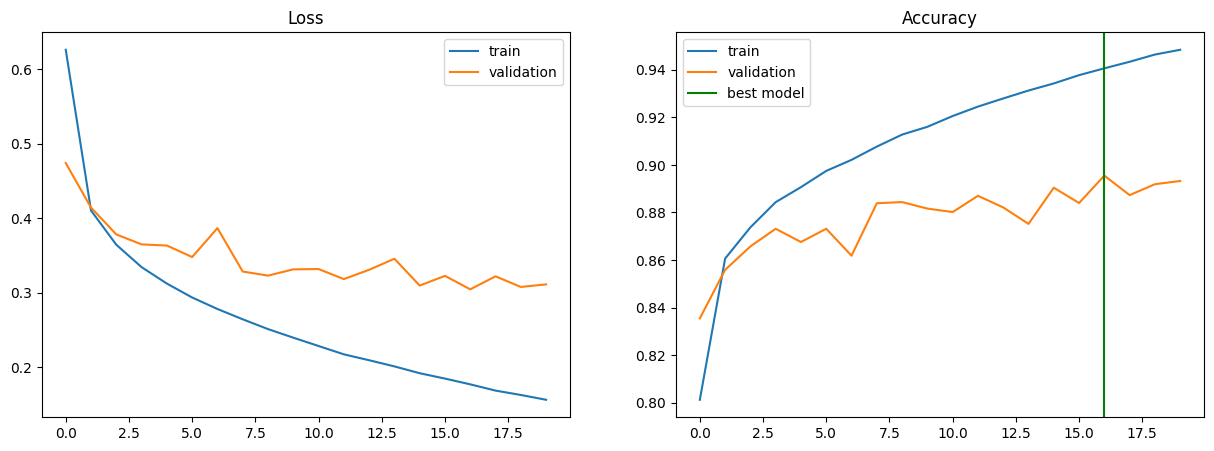

In [52]:
plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy, best_ep)

The best model was trained on 16-th epoch and achieved accuracy of $0.896 > 0.885$ on validation set (mnist_test in my case)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [239]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 80*80),
            nn.LeakyReLU(),
            nn.Linear(80*80, 80*80),
            nn.LeakyReLU(),
            nn.Linear(80*80, 80*80),
            nn.LeakyReLU(),
            nn.Linear(80*80, num_classes),
        )
        
    def forward(self, inp):  
        return self.model(inp)     

In [240]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 6400]       5,024,000
         LeakyReLU-3                 [-1, 6400]               0
            Linear-4                 [-1, 6400]      40,966,400
         LeakyReLU-5                 [-1, 6400]               0
            Linear-6                 [-1, 6400]      40,966,400
         LeakyReLU-7                 [-1, 6400]               0
            Linear-8                   [-1, 10]          64,010
Total params: 87,020,810
Trainable params: 87,020,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 331.96
Estimated Total Size (MB): 332.26
----------------------------------------------------------------


**I just added many "tall" layers for to enforce overfitting**

In [241]:
try:
    del model
except:
    pass

model = OverfittingNeuralNetwork().to(device)
opt = Adam(params=model.parameters(), lr=1e-4,) #eps=1e-8, betas=(0.9, 0.999), weight_decay=0.99) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

I will shrink train set size to 1000 data points and keep validation dataset the same

In [242]:
fmnist_dataset_train.data.shape, fmnist_dataset_train.targets.shape

(torch.Size([500, 28, 28]), torch.Size([500]))

In [243]:
N = 500
if fmnist_dataset_train.data.shape[0] > N:
    fmnist_dataset_train.data = fmnist_dataset_train.data[:N]
    fmnist_dataset_train.targets = fmnist_dataset_train.targets[:N]

In [244]:
train_loader_small = torch.utils.data.DataLoader(
    fmnist_dataset_train, batch_size=128, shuffle=True, num_workers=2
)

Text(0.5, 0, 'class label')

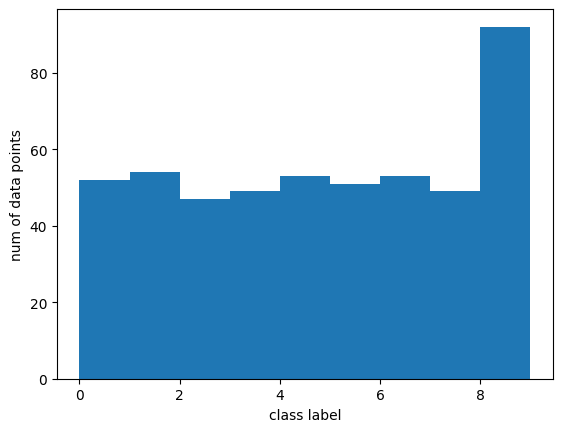

In [245]:
# just checking if our small subset if a representitive training set
labels_small = fmnist_dataset_train.targets.clone().detach().numpy()
a,b,c=plt.hist(labels_small, bins=range(0, 10))

plt.ylabel('num of data points')
plt.xlabel('class label')

# all classes are in the subset, so it is kinda OK (but look at the last class... there is one thing that can help us to overfit the model)

In [246]:
n_epochs = 35 # train it a bit longer to overfit

train_loss, train_accuracy, val_loss, val_accuracy, best_ep = train_model(model, train_loader_small, test_loader, loss_func, opt, n_epochs, chname='checkpoint_overfitting_1.pth')

Epoch 1 of 35 took 18.730s
	  training loss: 2.137739
	validation loss: 1.727414
	     train accuracy: 0.282
	validation accuracy: 0.608
Epoch 2 of 35 took 17.124s
	  training loss: 1.417020
	validation loss: 1.039184
	     train accuracy: 0.687
	validation accuracy: 0.660
Epoch 3 of 35 took 17.804s
	  training loss: 0.905033
	validation loss: 0.918976
	     train accuracy: 0.722
	validation accuracy: 0.697
Epoch 4 of 35 took 17.653s
	  training loss: 0.778772
	validation loss: 0.867820
	     train accuracy: 0.739
	validation accuracy: 0.682
Epoch 5 of 35 took 18.258s
	  training loss: 0.654593
	validation loss: 0.841030
	     train accuracy: 0.772
	validation accuracy: 0.700
Epoch 6 of 35 took 18.821s
	  training loss: 0.581479
	validation loss: 0.757186
	     train accuracy: 0.785
	validation accuracy: 0.713
Epoch 7 of 35 took 16.798s
	  training loss: 0.493649
	validation loss: 0.650646
	     train accuracy: 0.841
	validation accuracy: 0.770
Epoch 8 of 35 took 16.626s
	  training lo

Best model on 25 epoch
Validation accuracy 0.800
Train accuracy 1.000


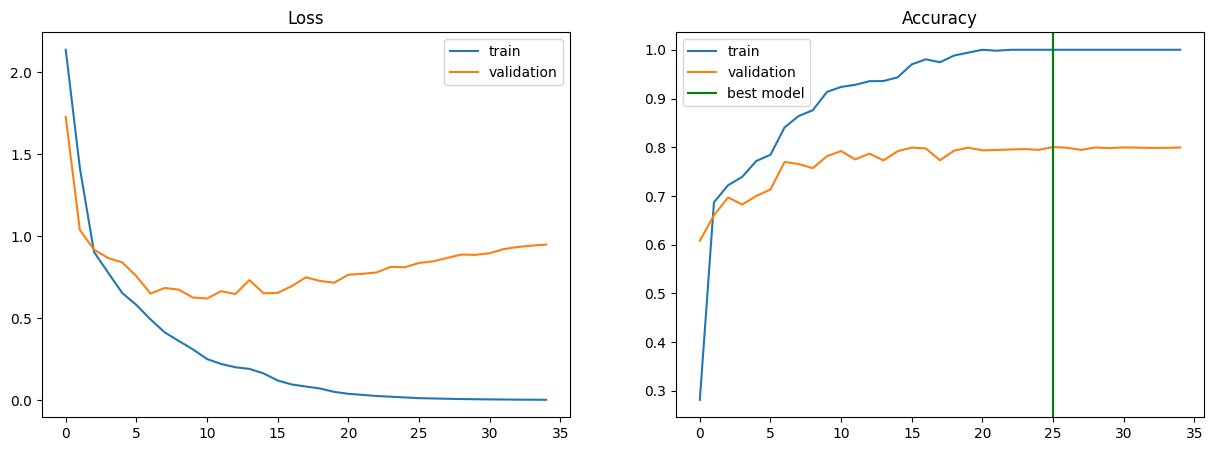

In [248]:
plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy, best_ep)

As we can see, the validation loss starts growing. That eventually lead to slight overfitting. Since we learn the probabitilties of a class membership, model can have high loss, but nevetheless achieve kinda OK accuracy (not horrendous). That means *model still guesses the right class label, but its decision is really uncertain* (most of the predicted probabilities are close to 50/50). 

The difference of accuracy on train and test is quite high

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [252]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 80*80),
            nn.LeakyReLU(),
            nn.Dropout(0.6),
            nn.Linear(80*80, 80*80),
            nn.LeakyReLU(),
            nn.Dropout(0.6),
            nn.Linear(80*80, 80*80),
            nn.LeakyReLU(),
            nn.Dropout(0.6),
            nn.Linear(80*80, num_classes),
        )

    def forward(self, inp):
        return self.model(inp)

**I just regularized previous model using `nn.Dropout` as it was suggested**

In [253]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 6400]       5,024,000
         LeakyReLU-3                 [-1, 6400]               0
           Dropout-4                 [-1, 6400]               0
            Linear-5                 [-1, 6400]      40,966,400
         LeakyReLU-6                 [-1, 6400]               0
           Dropout-7                 [-1, 6400]               0
            Linear-8                 [-1, 6400]      40,966,400
         LeakyReLU-9                 [-1, 6400]               0
          Dropout-10                 [-1, 6400]               0
           Linear-11                   [-1, 10]          64,010
Total params: 87,020,810
Trainable params: 87,020,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Fo

In [254]:
model_fixed = FixedNeuralNetwork().to(device)
opt_fixed = Adam(params=model_fixed.parameters(), lr=1e-4,) #eps=1e-8, betas=(0.9, 0.999), weight_decay=0.99) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [255]:
n_epochs = 25

train_loss, train_accuracy, val_loss, val_accuracy, best_ep = train_model(model_fixed, train_loader_small, test_loader, loss_func, opt_fixed, n_epochs, chname='checkpoint_regularized.pth')

Epoch 1 of 25 took 19.413s
	  training loss: 2.276704
	validation loss: 2.156955
	     train accuracy: 0.126
	validation accuracy: 0.320
Epoch 2 of 25 took 19.422s
	  training loss: 2.110150
	validation loss: 1.923949
	     train accuracy: 0.302
	validation accuracy: 0.514
Epoch 3 of 25 took 20.333s
	  training loss: 1.849380
	validation loss: 1.551901
	     train accuracy: 0.506
	validation accuracy: 0.578
Epoch 4 of 25 took 18.798s
	  training loss: 1.482668
	validation loss: 1.185818
	     train accuracy: 0.576
	validation accuracy: 0.642
Epoch 5 of 25 took 19.563s
	  training loss: 1.128948
	validation loss: 0.976757
	     train accuracy: 0.667
	validation accuracy: 0.661
Epoch 6 of 25 took 18.771s
	  training loss: 0.977481
	validation loss: 0.871134
	     train accuracy: 0.688
	validation accuracy: 0.669
Epoch 7 of 25 took 18.768s
	  training loss: 0.873128
	validation loss: 0.848378
	     train accuracy: 0.698
	validation accuracy: 0.684
Epoch 8 of 25 took 19.055s
	  training lo

Best model on 23 epoch
Validation accuracy 0.794
Train accuracy 0.900


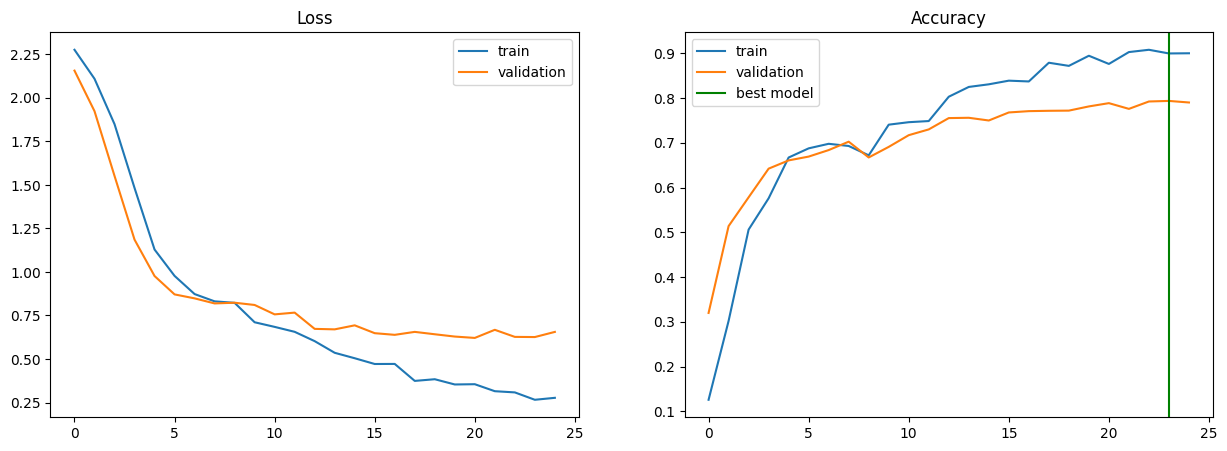

In [256]:
plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy, best_ep)

The loss bevahiour is now OK, accuracies are quite close. Model is not overfitted.

### Conclusions:
_Write down small report with your conclusions and your ideas._

In practice, it seems if u don't know the approximate number of parameters u need to train a decent model without running into overfitting, you should probably either look at some papers with similar datasets/tasks/etc. or try out some certain (presumably better architecture) and then use some regularizations.

I would've also tried this idea: compare two models in terms of variance of accuracies on many small subsets. Overfitted model have to have a higher variance. But it is impractical and should be done only for educational reasons. I actually tried it, but I got unnoticeable difference in variance. So, I deleted those cells in this)